In [2]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.

In [3]:
mask = ((ppmi_ad.obs['Age_Group'] == '30-50') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [4]:
ppmi_ad = ppmi_ad[mask]

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    f_classif,
    mutual_info_classif,
    chi2
)
from skfeature.function.similarity_based import fisher_score
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler

In [6]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [7]:
var_selector = VarianceThreshold(threshold=0.1)
X_highvar = var_selector.fit_transform(X)
selected_genes = X.columns[var_selector.get_support()]
print(f"After variance threshold: {len(selected_genes)} genes remaining")

After variance threshold: 56249 genes remaining


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_highvar)

In [9]:
n_top_genes = 20000

In [10]:
anova_scores, _ = f_classif(X_scaled, y)
top_indices_anovaf = np.argsort(anova_scores)[-n_top_genes:][::-1]
anova_selected_genes = selected_genes[top_indices_anovaf]
anova_scores = anova_scores[top_indices_anovaf]

In [11]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_processed = discretizer.fit_transform(X_scaled)
chi2_scores, _ = chi2(X_processed, y)
top_indices_chi2 = np.argsort(chi2_scores)[-n_top_genes:][::-1]
chi2_selected_genes = selected_genes[top_indices_chi2]
chi2_scores = chi2_scores[top_indices_chi2]

In [12]:
mutual_info_scores = mutual_info_classif(X_scaled, y)
top_indices_mutual_info = np.argsort(mutual_info_scores)[-n_top_genes:][::-1]
mutual_info_selected_genes = selected_genes[top_indices_mutual_info]
mutual_info_scores = mutual_info_scores[top_indices_mutual_info]

In [13]:
from skfeature.function.similarity_based import fisher_score
fisher_score = fisher_score.fisher_score(X_scaled, np.asarray(y))
top_indices_fisher = np.argsort(fisher_score)[-n_top_genes:][::-1]
fisher_selected_genes = selected_genes[top_indices_fisher]
fisher_score = fisher_score[top_indices_fisher]

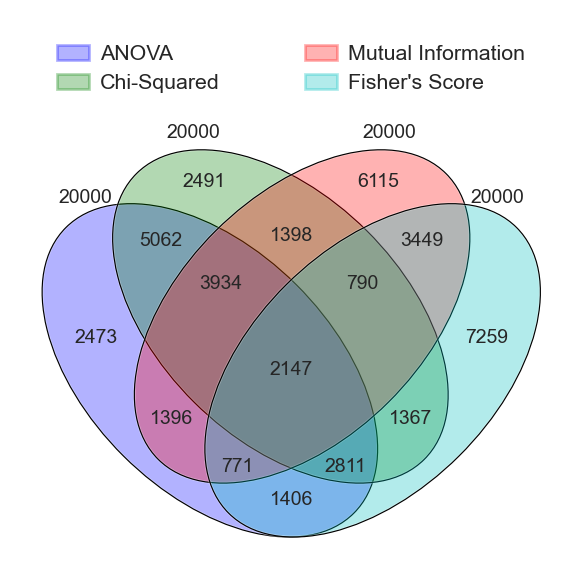

In [34]:
from venny4py.venny4py import *

sets = {
    'ANOVA': set(anova_selected_genes),
    'Chi-Squared': set(chi2_selected_genes),
    'Mutual Information': set(mutual_info_selected_genes),
    'Fisher\'s Score': set(fisher_selected_genes)
}
venny4py(sets=sets)


In [14]:
common_genes = set(anova_selected_genes) & set(chi2_selected_genes) & set(mutual_info_selected_genes) & set(fisher_selected_genes)
print(f"Number of common genes across methods: {len(common_genes)}")
print("Common genes:")
print(common_genes)

Number of common genes across methods: 2121
Common genes:
{'ENSG00000249744.1', 'ENSG00000189409.13', 'ENSG00000180172.7', 'ENSG00000283279.1', 'ENSG00000134207.16', 'ENSG00000270763.1', 'ENSG00000228838.1', 'ENSG00000228779.1', 'ENSG00000237786.1', 'ENSG00000119888.10', 'ENSG00000261104.1', 'ENSG00000222724.1', 'ENSG00000255033.1', 'ENSG00000284648.1', 'ENSG00000226869.6', 'ENSG00000259041.1', 'ENSG00000223684.1', 'ENSG00000185664.14', 'ENSG00000085274.15', 'ENSG00000280254.1', 'ENSG00000272703.1', 'ENSG00000233613.5', 'ENSG00000262008.1', 'ENSG00000270588.1', 'ENSG00000247157.6', 'ENSG00000198674.3', 'ENSG00000230130.1', 'ENSG00000256852.1', 'ENSG00000275497.1', 'ENSG00000222998.1', 'ENSG00000254674.1', 'ENSG00000281039.1', 'ENSG00000273730.1', 'ENSG00000275896.5', 'ENSG00000226061.1', 'ENSG00000162643.12', 'ENSG00000212158.1', 'ENSG00000250066.1', 'ENSG00000233803.9', 'ENSG00000218754.4', 'ENSG00000251368.1', 'ENSG00000272741.1', 'ENSG00000225911.1', 'ENSG00000275516.1', 'ENSG000002

In [15]:
method_collection = {
    'ANOVA': {
        'indices': top_indices_anovaf,
        'score': anova_scores,
        'genes': anova_selected_genes
    },
    'Chi-Squared': {
        'indices': top_indices_chi2,
        'score': chi2_scores,
        'genes': chi2_selected_genes
    },
    'Mutual Information': {
        'indices': top_indices_mutual_info,
        'score': mutual_info_scores,
        'genes': mutual_info_selected_genes
    },
    'Fisher\'s Score': {
        'indices': top_indices_fisher,
        'score': fisher_score,
        'genes': fisher_selected_genes
    }
}

### Alignment Verification

In [16]:
for method in method_collection:
    assert len(method_collection[method]['score']) == len(method_collection[method]['genes'])
    print(f"✅ {method}: Lengths match ({len(method_collection[method]['genes'])})")

✅ ANOVA: Lengths match (20000)
✅ Chi-Squared: Lengths match (20000)
✅ Mutual Information: Lengths match (20000)
✅ Fisher's Score: Lengths match (20000)


### Assign Ranks for Each Method

In [17]:
import numpy as np

for method in method_collection:
    # Sort genes by score (descending) and assign ranks
    sorted_indices = np.argsort(-np.array(method_collection[method]['score']))
    method_collection[method]['rank'] = np.arange(1, len(sorted_indices) + 1)
    method_collection[method]['genes'] = [method_collection[method]['genes'][i] for i in sorted_indices]

### Compute Borda Scores
___
The Borda count is a *rank aggregation* method that assigns a rank to each feature for each method used. A rank value of 1 indetifies the best rank. The ranks are summed across all methods. The lowest total score is considered a top pick for the consensus set. So the Borda score is the sum of a gene's rank in a method. The rank itself is assisgned according to the score from each method. So if the score provided by e.g. ANOVA is a high one, the rank the Borda method will assign will be low. For instance, the highest 'method' score will be equivalent to the rank 1 according to Borda.

In [18]:
from collections import defaultdict

# Get all unique genes across methods
gene_lists = [method_collection[method]['genes'] for method in method_collection]
all_genes = list(set().union(*gene_lists))

# Initialize Borda scores (default: high penalty for missing genes)
max_rank = max(len(method['genes']) for method in method_collection.values()) + 1
borda_scores = defaultdict(int)

for gene in all_genes:
    for method in method_collection:
        if gene in method_collection[method]['genes']:
            borda_scores[gene] += method_collection[method]['genes'].index(gene) + 1  # Rank = position + 1
        else:
            borda_scores[gene] += max_rank  # Penalize missing genes

### Sort Genes by Borda Score

In [19]:
ranked_genes = sorted(all_genes, key=lambda x: borda_scores[x])


### Display Top Consensus Genes

In [20]:
import pandas as pd

result_df = pd.DataFrame({
    "Gene": ranked_genes,
    "Borda_Score": [borda_scores[gene] for gene in ranked_genes],
    "Rank": np.arange(1, len(ranked_genes) + 1)
})

print("Top 10 Consensus Genes:")
print(result_df.head(10))

Top 10 Consensus Genes:
                Gene  Borda_Score  Rank
0  ENSG00000199319.1         2859     1
1  ENSG00000257434.1         3008     2
2  ENSG00000251707.2         3417     3
3  ENSG00000129845.5         4341     4
4  ENSG00000253391.1         4437     5
5  ENSG00000263730.1         4467     6
6  ENSG00000275497.1         4536     7
7  ENSG00000235819.1         5199     8
8  ENSG00000217686.2         5359     9
9  ENSG00000223309.1         5941    10


In [21]:
result_df

,Gene,Borda_Score,Rank
0,ENSG00000199319.1,2859,1
1,ENSG00000257434.1,3008,2
2,ENSG00000251707.2,3417,3
3,ENSG00000129845.5,4341,4
4,ENSG00000253391.1,4437,5
...,...,...,...
42853,ENSG00000085998.13,80001,42854
42854,ENSG00000213999.15,80001,42855
42855,ENSG00000232869.2,80002,42856
42856,ENSG00000257587.1,80003,42857


### Enrichment of Consensus Genes

In [22]:
result_df['Gene_Symbol'] = result_df['Gene'].map(
    dict(zip(ppmi_ad.varm['symbol_ensembl_mapping'].index,
             ppmi_ad.varm['symbol_ensembl_mapping']['gene_symbol']))
)

In [23]:
result_df

,Gene,Borda_Score,Rank,Gene_Symbol
0,ENSG00000199319.1,2859,1,RN7SKP25
1,ENSG00000257434.1,3008,2,ENSG00000257434
2,ENSG00000251707.2,3417,3,RNU7-68P
3,ENSG00000129845.5,4341,4,TTTY1
4,ENSG00000253391.1,4437,5,ENSG00000253391
...,...,...,...,...
42853,ENSG00000085998.13,80001,42854,POMGNT1
42854,ENSG00000213999.15,80001,42855,MEF2B
42855,ENSG00000232869.2,80002,42856,TRBV29-1
42856,ENSG00000257587.1,80003,42857,ENSG00000257587


In [24]:
import gseapy as gp

In [33]:
enr = gp.enrichr(gene_list=result_df['Gene_Symbol'][:40].to_list(),
                 gene_sets=['MSigDB_Hallmark_2020',
                            'KEGG_2021_Human',
                            'WikiPathways_2024_Human',
                            'Human_Phenotype_Ontology',
                            'GO_Biological_Process_2023',
                            'GO_Molecular_Function_2023',
                            'GO_Cellular_Component_2023',
                            'SynGO_2024',
                            'OMIM_Disease'],
                 organism='human')

/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/gseapy/enrichr.py:690: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


In [34]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Xenobiotic Metabolism,1/200,0.331292,0.331292,0,0,2.546193,2.812923,GCNT2
1,MSigDB_Hallmark_2020,Hypoxia,1/200,0.331292,0.331292,0,0,2.546193,2.812923,GCNT2
2,KEGG_2021_Human,Glycosphingolipid biosynthesis,1/45,0.086242,0.466533,0,0,11.606061,28.441835,GCNT2
3,KEGG_2021_Human,Autoimmune thyroid disease,1/53,0.100795,0.466533,0,0,9.816568,22.525762,IFNA7
4,KEGG_2021_Human,Cytosolic DNA-sensing pathway,1/63,0.118669,0.466533,0,0,8.229115,17.539685,IFNA7
...,...,...,...,...,...,...,...,...,...,...
94,GO_Molecular_Function_2023,Hexosyltransferase Activity (GO:0016758),1/96,0.175230,0.292049,0,0,5.361673,9.338205,GCNT2
95,GO_Molecular_Function_2023,Cytokine Activity (GO:0005125),1/178,0.300888,0.376109,0,0,2.865855,3.441946,IFNA7
96,GO_Molecular_Function_2023,Receptor Ligand Activity (GO:0048018),1/319,0.474694,0.474694,0,0,1.583777,1.180048,IFNA7
97,OMIM_Disease,blood,1/36,0.069595,0.089901,0,0,14.597070,38.902163,GCNT2


In [318]:
enr_res_pivot = enr.results.pivot(index='Term', columns='Genes', values='P-value')
enr_res_pivot = enr_res_pivot.fillna(1.0)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    enr_res_pivot,
    cmap='flare',
    fmt='.3f',
    vmin=0, vmax=1
)
plt.title("GSEA Results of Consensus Genes for Males Aged 30-50")

### Write results to a file

In [35]:
result_df.to_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection_borda_rank_consensus_males_30-50.csv")